In [38]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 11 15:47:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    32W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Find Normalization

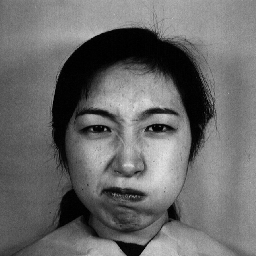

In [41]:
img_path = '../content/drive/MyDrive/Colab Notebooks/JAFFE/train/ANGRY/KA.AN1.39.tiff'
img = Image.open(img_path)
display(img)

In [42]:
img_np = np.array(img)

Text(0.5, 1.0, 'distribution of pixels')

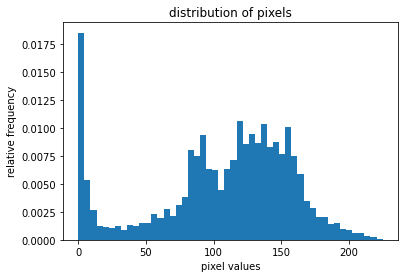

In [43]:
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

In [44]:
transform_img = transforms.Compose([
    transforms.ToTensor()
])

In [45]:
img_tr = transform_img(img)
  
img_np = np.array(img_tr)

Text(0.5, 1.0, 'distribution of pixels')

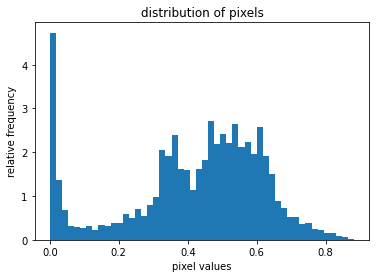

In [46]:
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

In [47]:
mean, std = img_tr.mean([1,2]), img_tr.std([1,2])

In [48]:
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

mean and std before normalize:
Mean of the image: tensor([0.4161])
Std of the image: tensor([0.2042])


Visualization

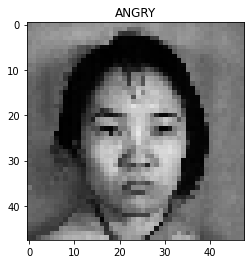

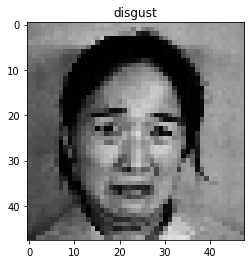

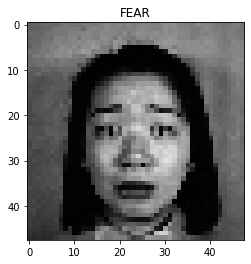

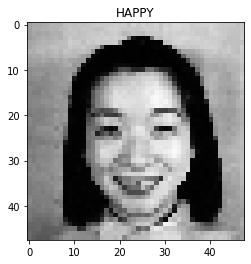

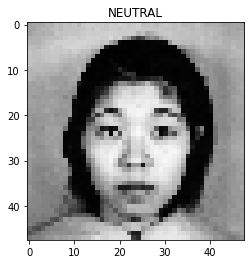

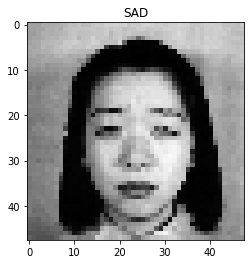

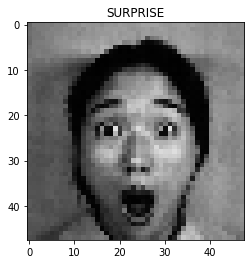

In [49]:
# Visualize one image from each category of the dataset

data_dir = ('../content/drive/MyDrive/Colab Notebooks/JAFFE/train/')
categories = ['ANGRY', 'disgust', 'FEAR', 'HAPPY', 'NEUTRAL', 'SAD', 'SURPRISE']
for i in categories:
    path = os.path.join(data_dir, i)
    num = 0
    
    for img in os.listdir(path):
        
        if num == 1:
            break
        
        else:
            img_array = cv2.imread(os.path.join(path,img))
            img_array = cv2.resize(img_array, (48, 48))
            plt.imshow(img_array)
            plt.title(i)
            plt.show()
            num +=1

In [50]:
image_files = os.listdir(path)
image = os.path.join(path, image_files[0])
image = cv2.imread(image)
image.shape

(256, 256, 3)

Transformations

In [51]:
from torchvision.transforms.transforms import RandomHorizontalFlip
train_transform = transforms.Compose([
      transforms.CenterCrop(200),
      # transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      # transforms.Pad(15),
      transforms.Resize(48),
      transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
      transforms.CenterCrop(200),
      transforms.ToTensor(),
      # transforms.Pad(15),
      transforms.Resize(48),
      transforms.Normalize(mean, std)
])

Datasets

In [52]:
root = '../content/drive/MyDrive/Colab Notebooks/JAFFE/'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'valid'), transform=test_transform)

In [53]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 143
     Root location: ../content/drive/MyDrive/Colab Notebooks/JAFFE/train
     StandardTransform
 Transform: Compose(
                CenterCrop(size=(200, 200))
                ToTensor()
                Resize(size=48, interpolation=bilinear, max_size=None, antialias=None)
                Normalize(mean=tensor([0.4161]), std=tensor([0.2042]))
            ), Dataset ImageFolder
     Number of datapoints: 70
     Root location: ../content/drive/MyDrive/Colab Notebooks/JAFFE/valid
     StandardTransform
 Transform: Compose(
                CenterCrop(size=(200, 200))
                ToTensor()
                Resize(size=48, interpolation=bilinear, max_size=None, antialias=None)
                Normalize(mean=tensor([0.4161]), std=tensor([0.2042]))
            ))

Load Data

In [54]:
torch.manual_seed(1234)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

In [55]:
print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['ANGRY', 'FEAR', 'HAPPY', 'NEUTRAL', 'SAD', 'SURPRISE', 'disgust']
Training images available: 143
Testing images available:  70


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 48, 48])
Label: [1 6 5 1 4 6 3 2 6 1]
Class: FEAR disgust SURPRISE FEAR SAD disgust NEUTRAL HAPPY disgust FEAR


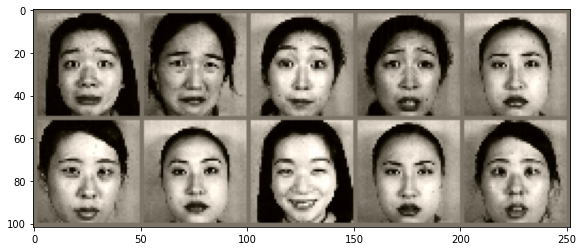

In [56]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

print(images.shape)
# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

Check the Shape

In [57]:
conv1 = nn.Conv2d(3, 16, 3, 1)
conv2 = nn.Conv2d(16, 64, 3, 1)

In [58]:
# Grab the first record
for i, (X_train, y_train) in enumerate(train_data):
    break

In [59]:
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)
x = X_train.view(1, 3, 48, 48)
print(x.shape)

torch.Size([1, 3, 48, 48])


In [60]:
x

tensor([[[[ 0.4814,  0.5657,  0.6461,  ...,  0.9919,  0.8941,  0.7749],
          [ 0.6093,  0.6425,  0.7929,  ...,  1.0393,  0.8861,  0.7205],
          [ 0.6337,  0.6353,  0.6721,  ...,  0.8530,  0.7561,  0.7378],
          ...,
          [-0.3362, -0.3764, -0.2101,  ...,  0.4149,  0.4221,  0.4007],
          [-0.4068, -0.3788, -0.3752,  ...,  0.3761,  0.1985,  0.2885],
          [-0.4638, -0.4964, -0.5361,  ...,  0.3775,  0.3069,  0.2501]],

         [[ 0.4814,  0.5657,  0.6461,  ...,  0.9919,  0.8941,  0.7749],
          [ 0.6093,  0.6425,  0.7929,  ...,  1.0393,  0.8861,  0.7205],
          [ 0.6337,  0.6353,  0.6721,  ...,  0.8530,  0.7561,  0.7378],
          ...,
          [-0.3362, -0.3764, -0.2101,  ...,  0.4149,  0.4221,  0.4007],
          [-0.4068, -0.3788, -0.3752,  ...,  0.3761,  0.1985,  0.2885],
          [-0.4638, -0.4964, -0.5361,  ...,  0.3775,  0.3069,  0.2501]],

         [[ 0.4814,  0.5657,  0.6461,  ...,  0.9919,  0.8941,  0.7749],
          [ 0.6093,  0.6425,  

In [61]:
# Perform the first convolution/activation
x = F.relu(conv1(x))
x.shape

torch.Size([1, 16, 46, 46])

In [62]:
# Run the first pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 16, 23, 23])


In [63]:
# Perform the second convolution/activation
x = F.relu(conv2(x))
print(x.shape)

torch.Size([1, 64, 21, 21])


In [64]:
# Run the second pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 64, 10, 10])


In [65]:
# Flatten the data
x = x.view(-1, 64*10*10)
print(x.shape)

torch.Size([1, 6400])


CNN Model

In [66]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 64, 3, 1)
        self.dr = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(10*10*64, 410)
        self.fc2 = nn.Linear(410, 84)
        self.fc3 = nn.Linear(84, 7)
        self.bnc1 = nn.BatchNorm1d(410)
        self.bnc2 = nn.BatchNorm1d(84)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        # X = self.bn1(X)
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        # X = self.bn2(X)
        # X = self.dr(X)
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 64*10*10)
        X = F.relu(self.fc1(X))
        # X = self.bnc1(X)
        X = self.fc2(X)
        # X = self.bnc2(X)
        X = self.fc3(X)
        X = self.dr(X)
        return F.log_softmax(X, dim=1)

Define Loss and Optimizer

In [67]:
torch.manual_seed(1234)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(CNNmodel.parameters(), lr=0.001)

In [68]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
  (dr): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6400, out_features=410, bias=True)
  (fc2): Linear(in_features=410, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
  (bnc1): BatchNorm1d(410, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnc2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Count Trainable Parameters

In [69]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [70]:
count_parameters(CNNmodel)

     432
      16
    9216
      64
      16
      16
      64
      64
 2624000
     410
   34440
      84
     588
       7
     410
     410
      84
      84
________
 2670405


Train the model

In [71]:
import time
start_time = time.time()

epochs = 50

max_trn_batch = 15
max_tst_batch = 7

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    CNNmodel.train()
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%5 == 0:
            acc = trn_corr.item()*100/(10*b)
            print(f'epoch: {i+1:2}  batch: {b:4}  loss: {loss.item():10.8f}  accuracy: {acc:7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    CNNmodel.eval()
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  1  batch:    5  loss: 1.93336165  accuracy:  10.000%
epoch:  1  batch:   10  loss: 2.07551980  accuracy:  15.000%
epoch:  1  batch:   15  loss: 1.95666182  accuracy:  13.333%
epoch:  2  batch:    5  loss: 1.98233604  accuracy:  22.000%
epoch:  2  batch:   10  loss: 1.96287978  accuracy:  13.000%
epoch:  2  batch:   15  loss: 1.93964899  accuracy:  14.000%
epoch:  3  batch:    5  loss: 1.94316840  accuracy:  16.000%
epoch:  3  batch:   10  loss: 1.90823054  accuracy:  17.000%
epoch:  3  batch:   15  loss: 1.93629122  accuracy:  18.667%
epoch:  4  batch:    5  loss: 1.86259711  accuracy:  32.000%
epoch:  4  batch:   10  loss: 1.82289755  accuracy:  29.000%
epoch:  4  batch:   15  loss: 1.83133495  accuracy:  30.000%
epoch:  5  batch:    5  loss: 1.64535177  accuracy:  20.000%
epoch:  5  batch:   10  loss: 1.69188046  accuracy:  26.000%
epoch:  5  batch:   15  loss: 2.02405572  accuracy:  30.667%
epoch:  6  batch:    5  loss: 1.72396255  accuracy:  40.000%
epoch:  6  batch:   10  

Plot Loss and Accuracy

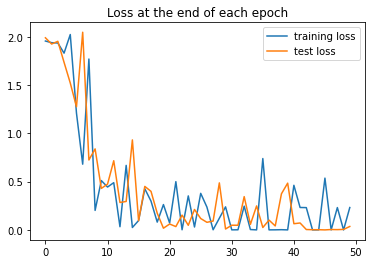

In [72]:
train_loss = [fl.item() for fl in train_losses]
test_loss = [fl.item() for fl in test_losses]
plt.plot(train_loss, label='training loss')
plt.plot(test_loss, label='test loss')
plt.title('Loss at the end of each epoch')
plt.legend()

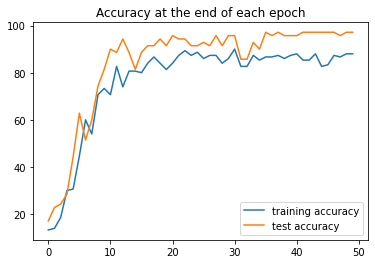

In [73]:
plt.plot([t/1.5 for t in train_correct], label='training accuracy')
plt.plot([t/0.7 for t in test_correct], label='test accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

Test Dataset

In [74]:
test_load_all = DataLoader(test_data, batch_size=70, shuffle=False)
CNNmodel.eval()
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = CNNmodel(X_test)  
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 68/70 =  97.143%
